# Important Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image, ImageFilter
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing import image
from keras.applications import ResNet50
import time

# Data Preprocessing

In [4]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, random_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define constants
image_size = (224, 224)
train_dir = '/kaggle/input/cv25-project-dataset/Project Data/Project Data/Train/images'
test_dir = '/kaggle/input/cv25-project-dataset/Project Data/Project Data/Val/images'  # Treat val as test
batch_size = 64
validation_split = 0.2  # 20% of training data for validation

# Function to load data
def load_data(data_dir):
    """Load images and labels from the directory."""
    images = []
    labels = []
    for label in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, label)
        if os.path.isdir(class_dir):
            main_label = label.split("___")[0]  # Extract main label
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                if os.path.isfile(img_path):
                    try:
                        img = Image.open(img_path).convert('RGB')
                        img = img.resize(image_size)
                        img_array = np.array(img)
                        images.append(img_array)
                        labels.append(main_label)
                    except Exception as e:
                        print(f"Error loading {img_path}: {e}")
    return np.array(images), np.array(labels)

# Load data
train_images, train_labels = load_data(train_dir)
test_images, test_labels = load_data(test_dir)

# Normalize images to [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

# Instantiate the encoder
label_encoder = LabelEncoder()

# Fit the encoder on the label data and transform
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Retrieve mappings
id2label = {idx: label for idx, label in enumerate(label_encoder.classes_)}
label2id = {label: idx for idx, label in id2label.items()}

num_classes = len(label_encoder.classes_)

# Compute class weights for imbalanced data
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels_encoded),
    y=train_labels_encoded
)
class_weights = dict(enumerate(class_weights))

# Split the training data into training and validation
train_size = int((1 - validation_split) * len(train_images))
val_size = len(train_images) - train_size
train_images, val_images = train_images[:train_size], train_images[train_size:]
train_labels_encoded, val_labels_encoded = train_labels_encoded[:train_size], train_labels_encoded[train_size:]

# Custom Dataset to wrap image and label arrays
class CustomImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2)  # Convert HWC to CHW
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {"pixel_values": self.images[idx], "labels": self.labels[idx]}

# Wrap training, validation, and test data
train_dataset = CustomImageDataset(train_images, train_labels_encoded)
val_dataset = CustomImageDataset(val_images, val_labels_encoded)
test_dataset = CustomImageDataset(test_images, test_labels_encoded)

# Now you can use `train_dataset`, `val_dataset`, and `test_dataset` for training, validation, and testing

# Data Visualization

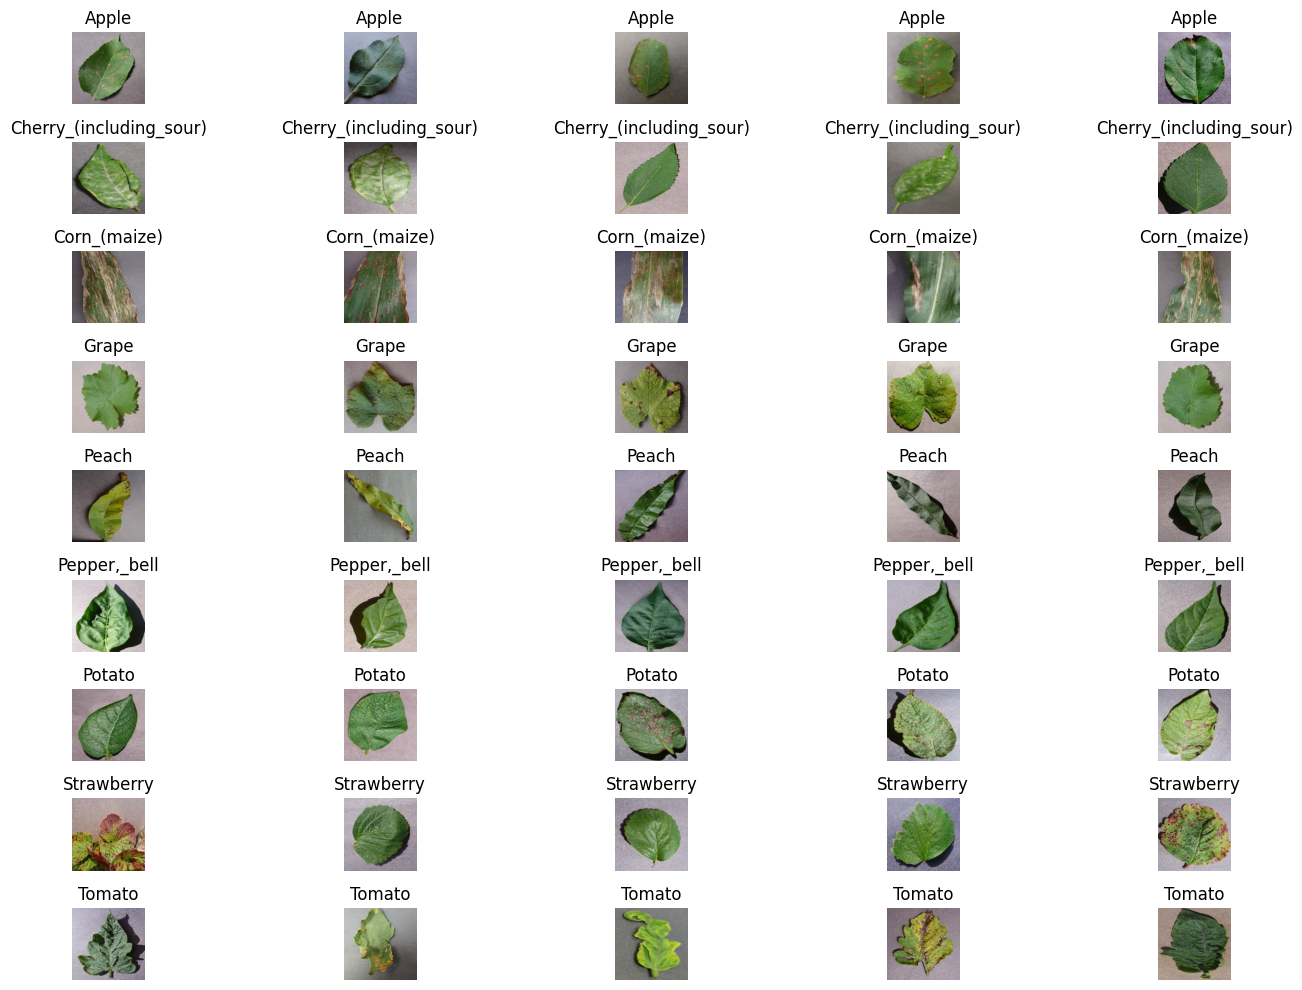

In [5]:
import matplotlib.pyplot as plt
import random
import numpy as np  # Ensure this is imported for `np.unique` and `np.where`

def visualize_samples(images, labels, label_encoder, num_samples=5):
    """Visualize a few sample images from each class."""
    unique_labels = np.unique(labels)
    plt.figure(figsize=(15, 10))
    for i, label in enumerate(unique_labels):
        label_indices = np.where(labels == label)[0]
        selected_indices = random.sample(list(label_indices), min(num_samples, len(label_indices)))
        for j, idx in enumerate(selected_indices):
            plt.subplot(len(unique_labels), num_samples, i * num_samples + j + 1)
            plt.imshow(images[idx])
            plt.title(label_encoder.inverse_transform([label])[0])
            plt.axis('off')
    plt.tight_layout()
    plt.show()

# Usage
visualize_samples(train_images, train_labels_encoded, label_encoder)


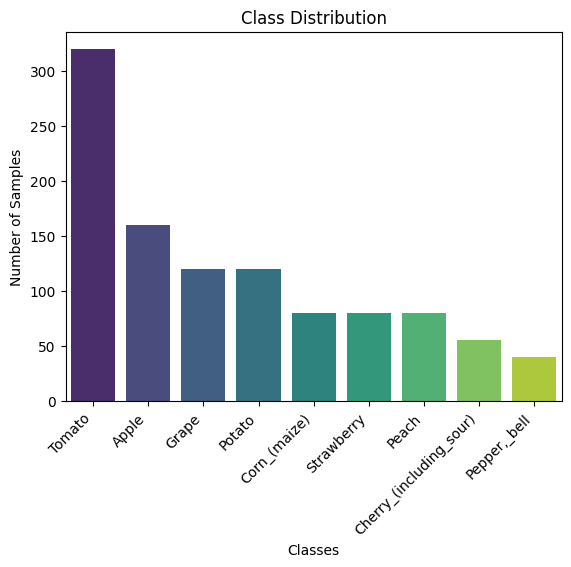

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_class_distribution(labels, label_encoder):
    """Plot the distribution of classes."""
    label_counts = pd.Series(labels).value_counts()
    label_names = label_encoder.inverse_transform(label_counts.index)
    sns.barplot(x=label_names, y=label_counts.values, palette="viridis")
    plt.xlabel('Classes')
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution')
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Usage
plot_class_distribution(train_labels_encoded, label_encoder)


In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

# ViT

In [8]:
!pip uninstall keras 
!pip install tf-keras

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Found existing installation: keras 3.3.3
Uninstalling keras-3.3.3:
  Would remove:
    /opt/conda/lib/python3.10/site-packages/keras-3.3.3.dist-info/*
    /opt/conda/lib/python3.10/site-packages/keras/*
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user


In [9]:
!pip install transformers

In [10]:
from transformers import ViTForImageClassification

In [11]:
from transformers import TrainingArguments, Trainer
import numpy as np

train_args = TrainingArguments(
    output_dir="output-models",
    save_total_limit=2,
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=20,  # Adjust epochs as needed
    weight_decay=0.01,
    logging_dir="logs",
    logging_steps=10,
    load_best_model_at_end=True,
    report_to="none",  # Avoid W&B if unnecessary
    remove_unused_columns=False,
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [12]:
# Load the ViT model from Hugging Face Transformers
model_name = "google/vit-base-patch16-224"  # Replace with your choice
model = ViTForImageClassification.from_pretrained(
    model_name,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

# Model loaded successfully
print(f"Model {model_name} loaded with {num_classes} classes.")

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([9]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([9, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model google/vit-base-patch16-224 loaded with 9 classes.


In [13]:
accuracy_list = []

# Modify the compute_metrics function to append accuracy to the list
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    accuracy = (predictions == labels).mean()
    
    # Append the accuracy value to the list
    accuracy_list.append(accuracy)
    
    return {"accuracy": accuracy}


In [14]:
from torch.nn import CrossEntropyLoss
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        """
        Custom loss computation with class weights.
        """
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Define CrossEntropyLoss with class weights
        loss_fn = CrossEntropyLoss(weight=torch.tensor(list(class_weights.values()), dtype=torch.float32).to(logits.device))
        loss = loss_fn(logits, labels)

        # Return loss and model outputs if needed
        return (loss, outputs) if return_outputs else loss


In [15]:
trainer = CustomTrainer(
    model=model,
    args=train_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=None,
    compute_metrics=compute_metrics,
)


/tmp/ipykernel_23/2209783986.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


In [16]:
import time

# Record start time
start_training_time = time.time()

# Start training
trainer.train()

# Record end time
end_training_time = time.time()


Epoch,Training Loss,Validation Loss,Accuracy
1,2.019300,1.728836,0.530303
2,0.745100,1.029315,0.787879
3,0.201500,0.589021,0.916667
4,0.087700,0.404890,0.943182
5,0.026600,0.339591,0.939394
6,0.013300,0.290407,0.962121
7,0.010900,0.264995,0.969697
8,0.007800,0.270906,0.965909
9,0.006200,0.253301,0.965909
10,0.005300,0.239382,0.969697


In [19]:
validation_accuracy = accuracy_list

training_time = end_training_time - start_training_time
print(f"validation Time: {training_time:.2f} seconds")
mean_accuracy = np.mean(validation_accuracy)
print(f"validation Accuracy: {mean_accuracy:.4f}")

Testing Time: 454.55 seconds
Testing Accuracy: 0.9333


#Validation Time: 454.55 seconds
#Validation Accuracy: 0.9333
#Testing Accuracy: 0.99

In [20]:
validation_accuracy = accuracy_list
print(validation_accuracy)

[0.5303030303030303, 0.7878787878787878, 0.9166666666666666, 0.9431818181818182, 0.9393939393939394, 0.9621212121212122, 0.9696969696969697, 0.9659090909090909, 0.9659090909090909, 0.9696969696969697, 0.9734848484848485, 0.9734848484848485, 0.9696969696969697, 0.9696969696969697, 0.9696969696969697, 0.9696969696969697, 0.9696969696969697, 0.9734848484848485, 0.9734848484848485, 0.9734848484848485]


In [21]:
from transformers import TrainingArguments, Trainer
import numpy as np

train_args = TrainingArguments(
    output_dir="output-models",
    save_total_limit=2,
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=20,  # Adjust epochs as needed
    weight_decay=0.01,
    logging_dir="logs",
    logging_steps=10,
    load_best_model_at_end=True,
    report_to="none",  # Avoid W&B if unnecessary
    remove_unused_columns=False,
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [22]:
# Load the ViT model from Hugging Face Transformers
model_name = "google/vit-base-patch16-224"  # Replace with your choice
model = ViTForImageClassification.from_pretrained(
    model_name,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

# Model loaded successfully
print(f"Model {model_name} loaded with {num_classes} classes.")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([9]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([9, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model google/vit-base-patch16-224 loaded with 9 classes.


In [23]:
accuracy_list = []

# Modify the compute_metrics function to append accuracy to the list
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    accuracy = (predictions == labels).mean()
    
    # Append the accuracy value to the list
    accuracy_list.append(accuracy)
    
    return {"accuracy": accuracy}


In [24]:
from torch.nn import CrossEntropyLoss
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        """
        Custom loss computation with class weights.
        """
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Define CrossEntropyLoss with class weights
        loss_fn = CrossEntropyLoss(weight=torch.tensor(list(class_weights.values()), dtype=torch.float32).to(logits.device))
        loss = loss_fn(logits, labels)

        # Return loss and model outputs if needed
        return (loss, outputs) if return_outputs else loss


In [25]:
trainer = CustomTrainer(
    model=model,
    args=train_args,
    train_dataset=train_dataset,
    eval_dataset=train_dataset,
    tokenizer=None,
    compute_metrics=compute_metrics,
)


/tmp/ipykernel_23/86485028.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


In [26]:
import time

# Record start time
start_training_time = time.time()

# Start training
trainer.train()

# Record end time
end_training_time = time.time()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.929000,1.083248,0.823864
2,0.700100,0.354976,0.987689
3,0.169800,0.100587,0.999053
4,0.073400,0.034159,1.000000
5,0.022500,0.016373,1.000000
6,0.012300,0.010918,1.000000
7,0.010600,0.008500,1.000000
8,0.007800,0.006946,1.000000
9,0.006300,0.005979,1.000000
10,0.005300,0.005264,1.000000


In [27]:
training_accuracy = accuracy_list
print(training_accuracy)

[0.8238636363636364, 0.9876893939393939, 0.9990530303030303, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [28]:
training_time = end_training_time - start_training_time
print(f"Training Time: {training_time:.2f} seconds")
mean_accuracy = np.mean(training_accuracy)
print(f"Training Accuracy: {mean_accuracy:.4f}")

Training Time: 549.77 seconds
Training Accuracy: 0.9905


In [29]:
from sklearn.metrics import recall_score, accuracy_score, f1_score, classification_report

# Use the trainer to make predictions on the test dataset
outputs = trainer.predict(test_dataset)

# Print the evaluation metrics (accuracy, loss, etc.) from the trainer
print(outputs.metrics)

# Get the predicted labels and true labels
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(axis=-1)  # Get the predicted class labels

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Calculate recall for each class
recall = recall_score(y_true, y_pred, average=None)

# Print recall for each class
for label, score in zip(label_encoder.classes_, recall):
    print(f"Recall for {label}: {score:.2f}")

# Calculate F1 score for each class (optional)
f1 = f1_score(y_true, y_pred, average=None)
for label, score in zip(label_encoder.classes_, f1):
    print(f"F1 Score for {label}: {score:.2f}")

# Detailed classification report (precision, recall, f1-score)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

{'test_loss': 0.06413153558969498, 'test_accuracy': 0.9878787878787879, 'test_runtime': 2.0128, 'test_samples_per_second': 163.951, 'test_steps_per_second': 2.981}
Accuracy: 0.99
Recall for Apple: 1.00
Recall for Cherry_(including_sour): 1.00
Recall for Corn_(maize): 1.00
Recall for Grape: 1.00
Recall for Peach: 0.95
Recall for Pepper,_bell: 0.90
Recall for Potato: 1.00
Recall for Strawberry: 1.00
Recall for Tomato: 0.99
F1 Score for Apple: 0.99
F1 Score for Cherry_(including_sour): 1.00
F1 Score for Corn_(maize): 1.00
F1 Score for Grape: 1.00
F1 Score for Peach: 0.95
F1 Score for Pepper,_bell: 0.95
F1 Score for Potato: 0.97
F1 Score for Strawberry: 1.00
F1 Score for Tomato: 0.99

Classification Report:
                         precision    recall  f1-score   support

                  Apple       0.98      1.00      0.99        40
Cherry_(including_sour)       1.00      1.00      1.00        20
           Corn_(maize)       1.00      1.00      1.00        40
                  Grape   

In [30]:
print("\nClassification Report of ViT:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))


Classification Report of ViT:
                         precision    recall  f1-score   support

                  Apple       0.98      1.00      0.99        40
Cherry_(including_sour)       1.00      1.00      1.00        20
           Corn_(maize)       1.00      1.00      1.00        40
                  Grape       1.00      1.00      1.00        40
                  Peach       0.95      0.95      0.95        20
           Pepper,_bell       1.00      0.90      0.95        20
                 Potato       0.94      1.00      0.97        30
             Strawberry       1.00      1.00      1.00        20
                 Tomato       1.00      0.99      0.99       100

               accuracy                           0.99       330
              macro avg       0.98      0.98      0.98       330
           weighted avg       0.99      0.99      0.99       330



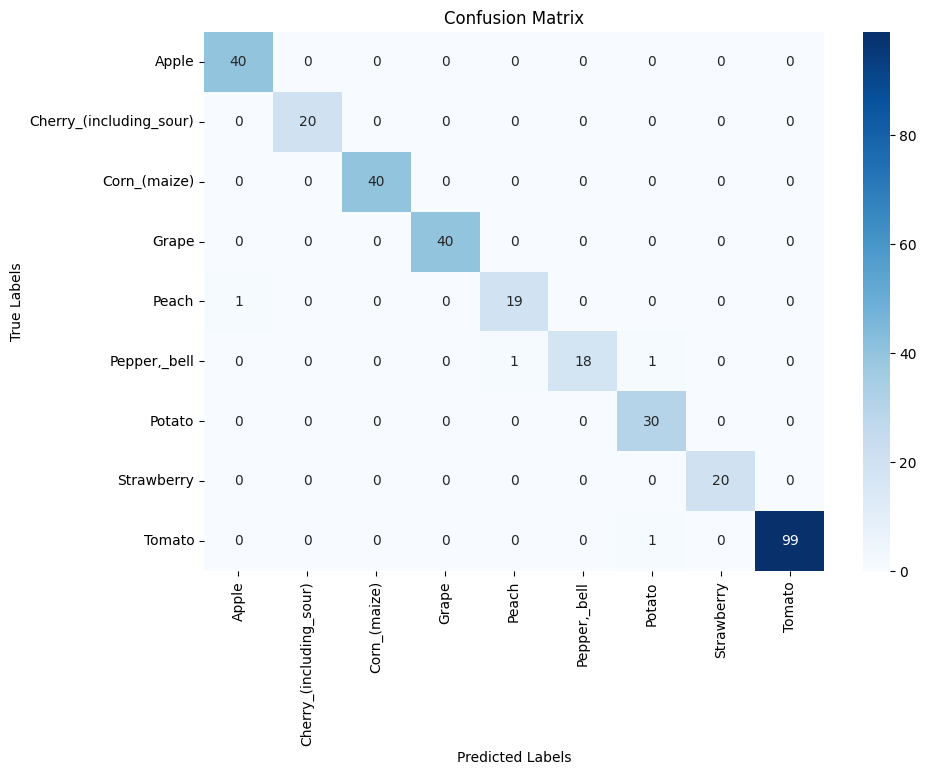

In [31]:
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix with plant names as labels
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


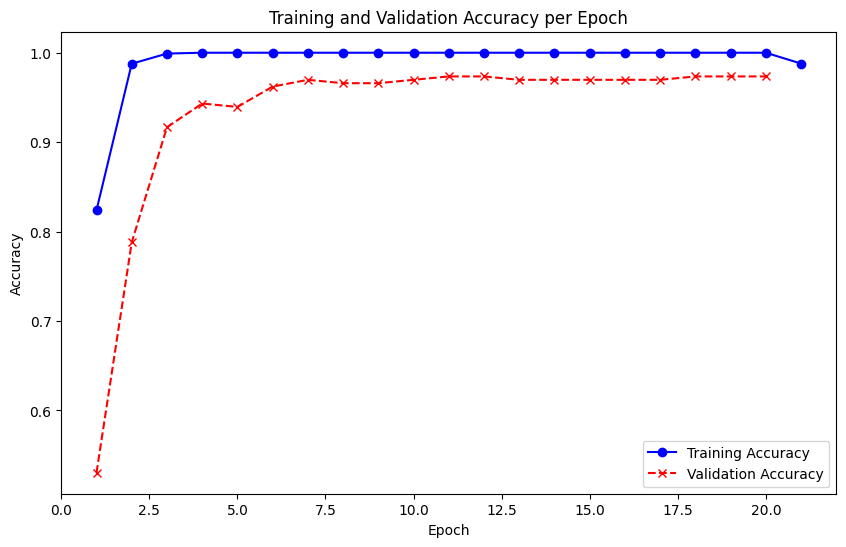

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(training_accuracy) + 1), training_accuracy, label='Training Accuracy', marker='o', linestyle='-', color='b')
plt.plot(range(1, len(validation_accuracy) + 1), validation_accuracy, label='Validation Accuracy', marker='x', linestyle='--', color='r')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy per Epoch')

# Adding legend
plt.legend()

# Display the plot
plt.show()


In [33]:
trainer.save_model("final_model")